# Laboratory work  2

**Фильтрация изображений**

Completed: гр.№ 6131-010402D, Griaznov Ilia

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import random
import copy
import json
import itertools
from itertools import repeat
import cv2
from random import randint
from IPython.display import clear_output
from typing import Optional
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

%matplotlib inline

1. Считать цветное rgb изображение
2. Зашумить изображение аддитивным шумом с вероятностью p (по вариантам).
  *   Вход: изображение из пункта 1
  *   Вывод: зашумленное изображение
3. Написать функцию реализации ранговой фильтрации

> Функцию вида fun(Image, window, rank)  
Где window  - окно фильтрации (по вариантам)  
rank - опциональный параметр, значение ранга в ранговой фильтрации


4. Отфильтровать зашумленное изображение со всеми возможными рангами (кол-во рангов зависит от окна по вариантам).  
Подсчитать СКО для результата фильтрации с каждым рангом.
  *   Вход: изображение из пункта 2
  *   Вывод: Значения СКО для каждого ранга. Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованные изображения для первого, последнего ранга, а так же для ранга с наименьшим СКО.
  *   СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1
5. Написать функцию реализации свертки

> Функцию вида fun(mat1, mat2)  
Где mat1  - первый сигнал. В данном случае изображение  
mat2 - второй сигнал. В данном ядро КИХ фильтра

6. Отфильтровать изображение КИХ фильтром с ядром заданным по вариантам. Подсчитать СКО. Сравнить с результатами пункта 4.
  *   Вход: изображение из пункта 2
  *   Вывод: Значения СКО . Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованное изображение.
  *   СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

  
    
    
*Для работы с изображением использовать OpenCV (открытие, сохранение и т.д.). Для визуализации можно использовать matplotlib. Все необходимые для задания функции реализовавать самим, а не использовать готовые в OpenCV, если не указано обратного. С изображениями работать с цветными по каждому из каналов.*

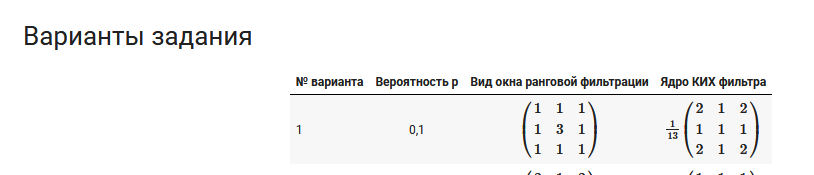

In [2]:
p = 0,1
RANK = 1
kernel = np.array([[1, 1, 1],
                   [1, 3, 1],
                   [1, 1, 1]], dtype='uint8')

FIR_KERNEL = (1/13) * np.array([
    [2, 1, 2], 
    [1, 1, 1], 
    [2, 1, 2]
])

Касательно замечания насчет варианта не совсем понял... в kernel передаю согласно своему варианту значеия. это же мой вариант

### 1. Считать цветное rgb изображение

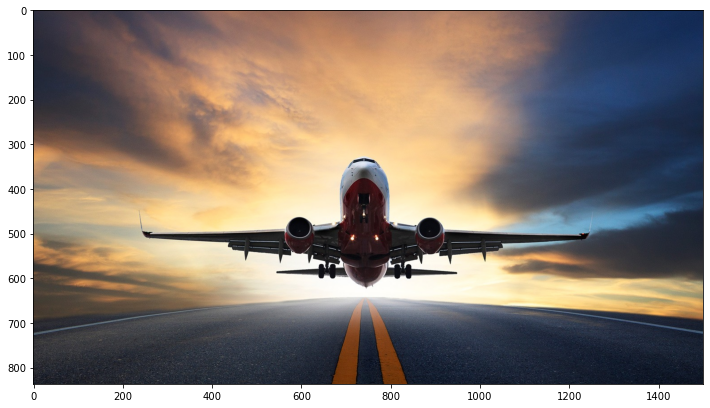

In [3]:
img = cv2.imread('img/fly.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img)

In [4]:
img.shape

(837, 1500, 3)

### 2. Зашумить изображение аддитивным шумом с вероятностью p (по вариантам).

In [5]:
def noise(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rand = randint(0,100)
            if rand < 1:
                img[i][j] = img[i][j] + randint(0, 255-max(img[i][j]))
    return img         

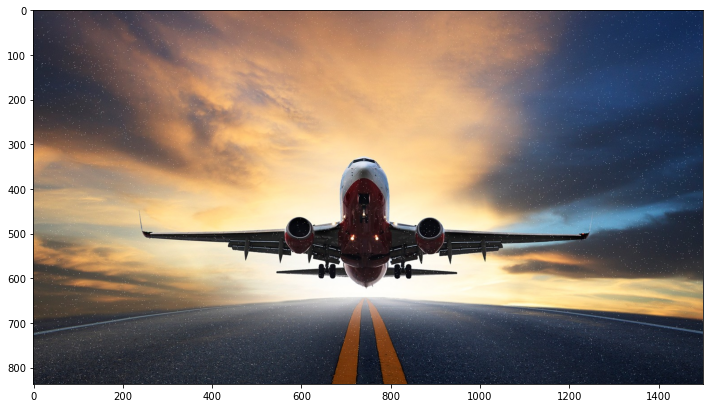

In [6]:
img_noise = noise(img)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot()
ax.imshow(img_noise)
plt.show()   

### 3. Написать функцию реализации ранговой фильтрации

In [7]:
def rank_filter(img: np.array, kernel: np.array, rank: int)->np.array:
    result = np.array(img, dtype=img.dtype)
    rows, cols, channels = img.shape[0], img.shape[1], img.shape[2]
    halfKernelSize = len(kernel) // 2
    for ch in range(channels):
        for i in range(0, rows):
            for j in range(0, cols):
                series = [] # вариационный ряд
                for p in range(-halfKernelSize, halfKernelSize + 1):  # по строкам ядра
                    for q in range(-halfKernelSize, halfKernelSize + 1):  # по столбцам ядра
                        amount = kernel[p + halfKernelSize][q + halfKernelSize]  # число, лежащее в p,q ячейке ядра
                        padP = p if i + p < rows and i + p > 0 else 0  # обработка выхода за границы массива по строкам
                        padQ = q if j + q < cols and j + q > 0 else 0  # обработка выхода за границы массива по столбцам
                        val = img[i + padP, j + padQ, ch]  # само число вариационного ряда
                        for _ in range(amount):
                            series.append(val)
                series = sorted(series)
                result[i, j, ch] = series[rank]
    
    return result

### 4. Отфильтровать зашумленное изображение со всеми возможными рангами (кол-во рангов зависит от окна по вариантам). Подсчитать СКО для результата фильтрации с каждым рангом.

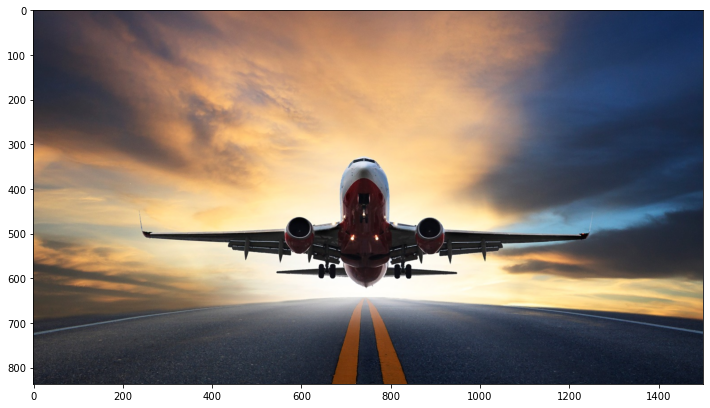

In [8]:
rank_filtered_img = rank_filter(img_noise, kernel, 6)
plt.subplots(figsize=(12,12))
plt.imshow(rank_filtered_img)

In [9]:
def get_amount_of_pixels_in_window(kernel: np.array)->int:
    """
    Возвращает количество элементов а вариационном ряде на основе значений ядра окна
    """
    amount = 0
    for row in kernel:
        for j in range(len(row)):
            amount = amount + row[j]
    return amount

In [10]:
N = get_amount_of_pixels_in_window(kernel)
print("N =",N)
channel = [0, 1, 2]
rang_image_list = []
for i in range(0, N):
    rang_image = rank_filter(img_noise, kernel, i)
    rang_image_list.append(rang_image)
    mse = 0
    for j in channel:
        mse += np.mean((img[:,:,j] - rang_image[:,:,j])**2)
    print("MSE: ", mse/len(channel), ", rank: ", i)

N = 11
MSE:  28.76544590468605 , rank:  0
MSE:  19.98744218770742 , rank:  1
MSE:  14.33719819461038 , rank:  2
MSE:  9.139293774060798 , rank:  3
MSE:  6.852526217974247 , rank:  4
MSE:  6.331118014071419 , rank:  5
MSE:  6.838727200318599 , rank:  6
MSE:  9.246083897517588 , rank:  7
MSE:  13.89741484136466 , rank:  8
MSE:  20.191667861409798 , rank:  9
MSE:  33.26753750165937 , rank:  10


### Вывод:

Выше наглядно видно СКО (MSE) для каждого просчитанного ранга. Из расчета среднеквадратичного отклонения наглядно видно, что наименьшее отклонение СКО при ранге = 5 : `MSE:  6.358890481879729 , rank:  5`


### 5. Написать функцию реализации свертки

Повернул ядро функцией транспонирования

In [11]:
def convolution(img, kernel):
    r,g,b = img[:,:,0], img[:,:,1],img[:,:,2]
    r_copy, g_copy, b_copy = np.array(r,copy=True),np.array(g,copy=True),np.array(b,copy=True)
    l = len(kernel)
    step = int((l+1)/2-1)
    for i in range(step, len(img)-step):
        for j in range(step, len(img[0])-step):
            window_red = r[i - step: i + step + 1, j - step: j + step + 1]
            window_green = g[i - step: i + step + 1, j - step: j + step + 1]
            window_blue = b[i - step: i + step + 1, j - step: j + step + 1]
            r_copy[i][j] = sum(sum(np.array(window_red)*kernel.T))  
            g_copy[i][j] = sum(sum(np.array(window_green)*kernel.T)) 
            b_copy[i][j] = sum(sum(np.array(window_blue)*kernel.T))  
    return np.dstack((r_copy,g_copy,b_copy))

### 6. Отфильтровать изображение КИХ фильтром с ядром заданным по вариантам. Подсчитать СКО. Сравнить с результатами пункта 4.

In [12]:
img_kix = convolution(img_noise, FIR_KERNEL)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x18bd7592580>)

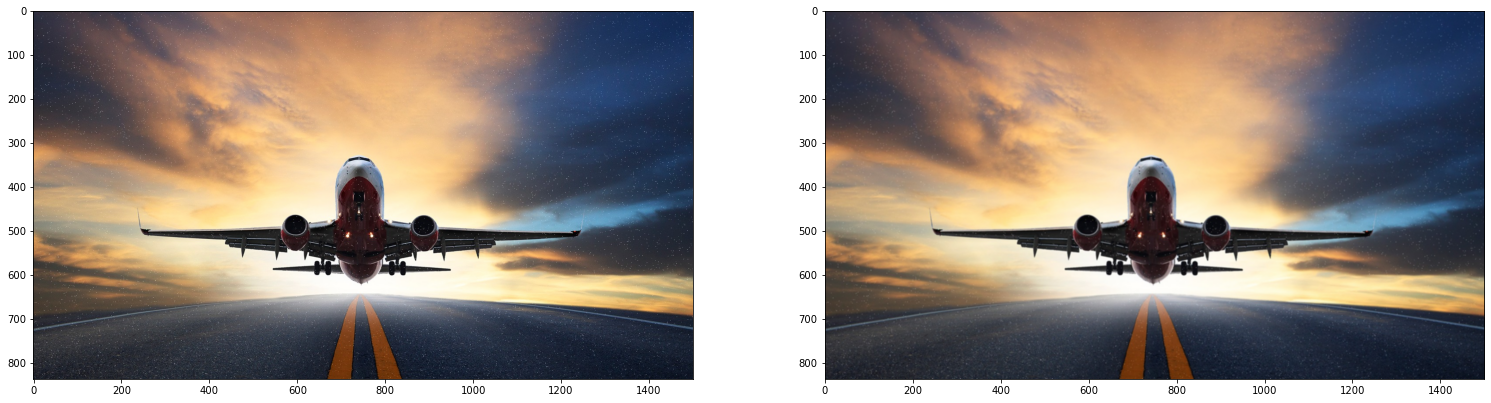

In [13]:
plt.figure(figsize=(26,26))
plt.subplot(221),plt.imshow(img_noise)
plt.subplot(222),plt.imshow(img_kix)

In [14]:
square_sum = np.sum((img_kix - rank_filtered_img)**2)
count = rank_filtered_img.size
mse = np.sqrt(square_sum / count)
mse

3.013011519664188

###  Вывод:
Из итогового выхода СКО получаем: `10.391174225856993` - что в целом, как цифрвое значение, в качестве результата могло бы быть удовлетворительным, но наглядно видны артефакты на полученном изображении. От сюда можно селать вывод, что СКО полученное в 4 пункте явно предосходит. 